# Exploratory Data Analysis

In [1]:
from fog.code.utils.utils import *
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit, col, sum
from pyspark.sql.types import StringType, BooleanType, IntegerType, FloatType, DateType
import seaborn as sns
spark = SparkSession.builder.appName("PySpark Cloud Test").getOrCreate()
# conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '16g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','16g')])

## Contents
- Load Data
- Target variable distribution
    - Distribution for 3 main measurements  
    - Joint distribution for all 3 choose 2 combinations.  
    - Distributions by tasks  
- Lag Correlation

## To Do 
- Analyze aceleromter distros by task  
- Calculate variance of last 10 time steps  

## Load Data 

In [2]:
df = spark.read.parquet("gs://msca-bdp-student-gcs/parkinsons_data/train/processed/defog_tasks_lagging")

In [5]:
df.printSchema()

root
 |-- Subject: string (nullable = true)
 |-- Visit: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- AccV: float (nullable = true)
 |-- AccML: float (nullable = true)
 |-- AccAP: float (nullable = true)
 |-- StartHesitation: integer (nullable = true)
 |-- Turn: integer (nullable = true)
 |-- Walking: integer (nullable = true)
 |-- Valid: boolean (nullable = true)
 |-- Task: boolean (nullable = true)
 |-- SourceDefog: integer (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- YearsSinceDx: integer (nullable = true)
 |-- UPDRSIII_On: integer (nullable = true)
 |-- UPDRSIII_Off: integer (nullable = true)
 |-- NFOGQ: integer (nullable = true)
 |-- Test: string (nullable = true)
 |-- TimeSeconds: double (nullable = true)
 |-- Begin: double (nullable = true)
 |-- End: double (nullable = true)
 |-- TaskType: string (nullable = true)
 |-- MB9: integer (nul

In [6]:
df.count()

13525703

## Target Variable Distribution

In [7]:
target_count = df.select("target").groupBy("target").count().toPandas()
target_count

,target,count
0,1,500
1,3,92401
2,2,568265
3,0,12864537


In [5]:
12000000 * .0001

1200.0

In [7]:
568265 * .002

1136.53

In [9]:
92401 * .01

924.01

<AxesSubplot:xlabel='target', ylabel='count'>

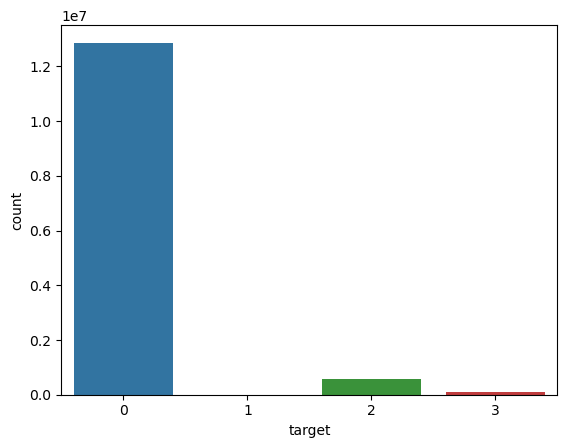

In [8]:
sns.barplot(data=target_count, x='target', y='count')

No symptom (0) is the most common and "StartHesitation" is nearly non-existant. We will need to employ a sampling strategy to balance classes.  

In [77]:
# 5% overall sample
acc_measures = df.select("AccV", "AccML", "AccAP","NFOGQ", "target") \
    .sample(fraction=0.05, seed=37) \
    .toPandas()

In [84]:
# manually balance by taking ~1,000 from 0, 2 and 3, and all of class 1 (~500)
fractions = [.0001, 1, .002, .01 ]
for i in [0, 1, 2, 3]:
    df_filt = df.select("AccV", "AccML", "AccAP","NFOGQ", "Age", "Sex", "Medication", "target") \
        .filter(df.target == i) \
        .sample(fraction=float(fractions[i]))
    if i == 0:
        df_sample = df_filt
    else:
        df_sample = df_sample.union(df_filt)
        

In [85]:
df_sample = df_sample.toPandas()

In [10]:
acc_measures.groupby('target').size()

target
0    643327
1        23
2     28456
3      4684
dtype: int64

Took 5% sample to visualize data without crashing cluster. Sample of "StartHesitation" has only 23 observations, so visuals are not very stable for that class. 

(-1.0, 1.0)

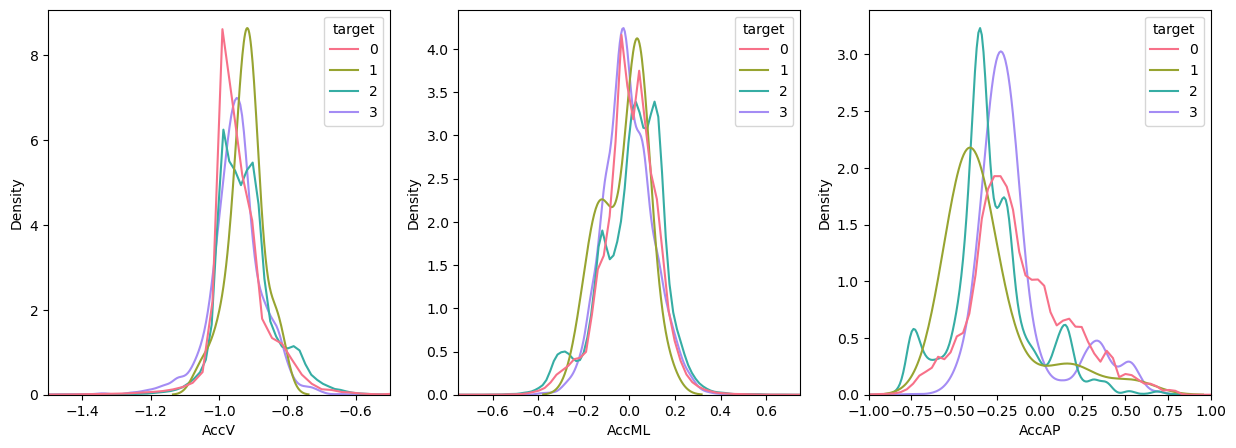

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(data=acc_measures, x="AccV", hue="target", common_norm=False, palette=sns.color_palette("husl", 4),  ax=axs[0])
axs[0].set_xlim(-1.5,-0.5)
sns.kdeplot(data=acc_measures, x="AccML", hue="target", common_norm=False, palette=sns.color_palette("husl", 4),  ax=axs[1])
axs[1].set_xlim(-.75,.75)
sns.kdeplot(data=acc_measures, x="AccAP", hue="target", common_norm=False, palette=sns.color_palette("husl", 4),  ax=axs[2])
axs[2].set_xlim(-1,1)

### Joint distributions by target class


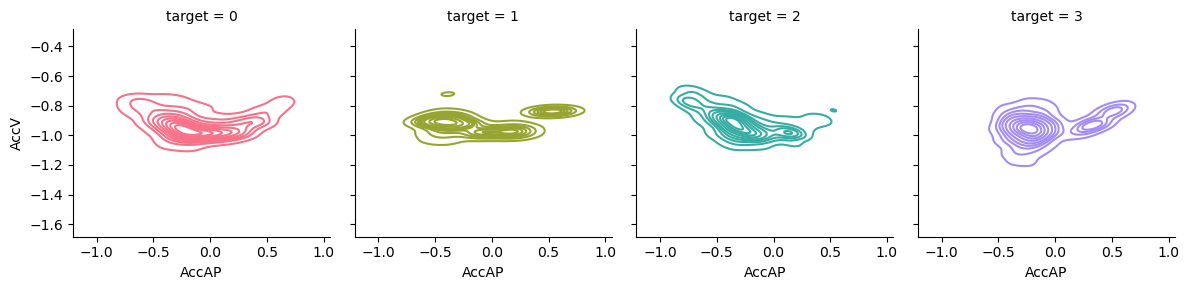

In [20]:
g = sns.FacetGrid(df_sample, col="target", hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "AccAP", "AccV")

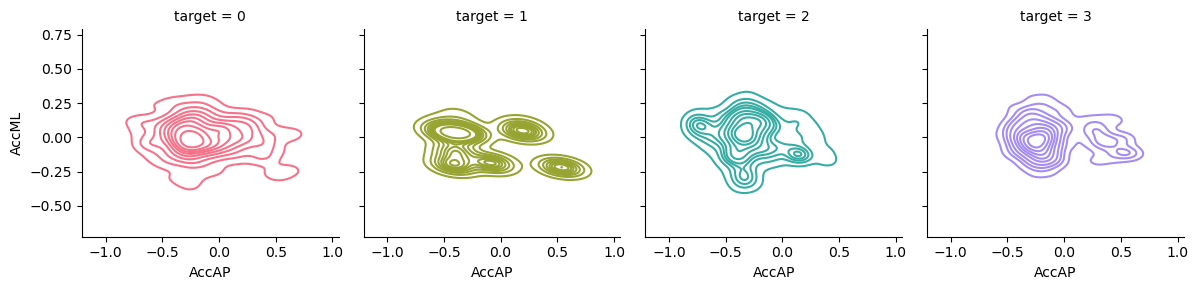

In [21]:
g = sns.FacetGrid(df_sample, col="target", hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "AccAP", "AccML")

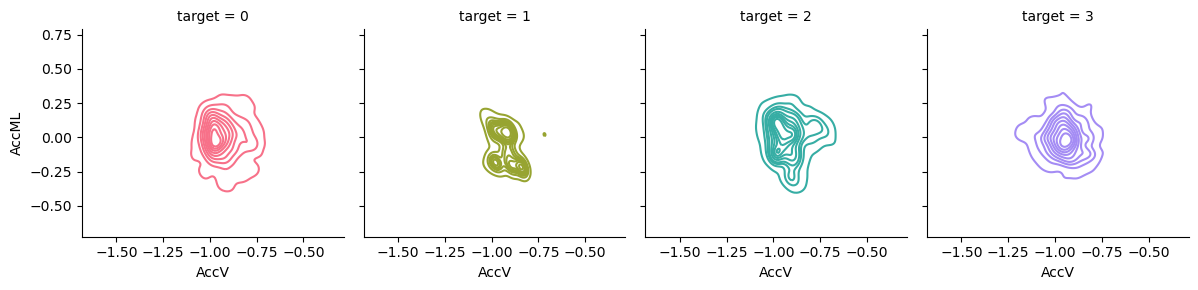

In [23]:
g = sns.FacetGrid(df_sample, col="target", hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "AccV", "AccML")

### Task and Target Measurement Distributions

## Lag correlation

In [24]:
cols = df.columns

def select_cols(match_string):
    cols_list = []
    for c in cols:
        if c.startswith(match_string):
            cols_list.append(c)
    return cols_list
acc_v_cols = select_cols('AccV')
acc_ml_cols = select_cols('AccML')
acc_ap_cols = select_cols('AccAP')



In [25]:
df_acc_v = df.select(*acc_v_cols)
df_acc_ml = df.select(*acc_ml_cols)
df_acc_ap = df.select(*acc_ap_cols)

In [45]:
acc_ap = df_acc_ap.sample(fraction=.05) \
    .toPandas() \

acc_ml = df_acc_ml.sample(fraction=.05) \
    .toPandas()

acc_v = df_acc_v.sample(fraction=.05) \
    .toPandas()

In [47]:
acc_v_corr = acc_v.corr()
acc_ml_corr = acc_ml.corr()
acc_ap_corr = acc_ap.corr()

<AxesSubplot:ylabel='AccAP'>

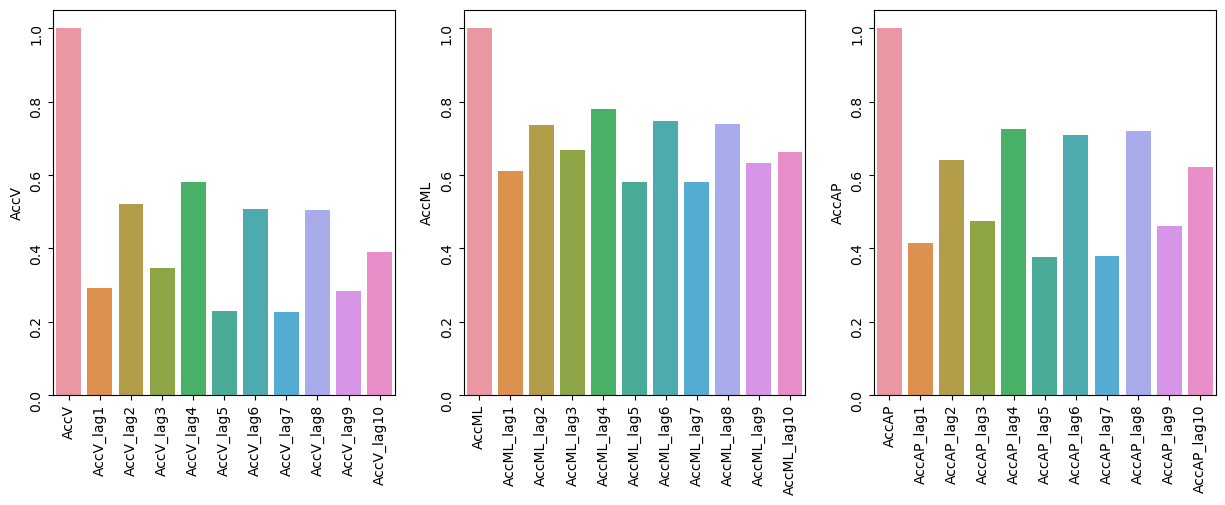

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].tick_params(labelrotation=90)
axs[1].tick_params(labelrotation=90)
axs[2].tick_params(labelrotation=90)
sns.barplot(y=acc_v_corr.iloc[0], x=acc_v_corr.index, ax=axs[0])
sns.barplot(y=acc_ml_corr.iloc[0], x=acc_ml_corr.index, ax=axs[1])
sns.barplot(y=acc_ap_corr.iloc[0], x=acc_ap_corr.index, ax=axs[2])
#plt.xticks(rotation = 45)

### Task, target, and measurement distributions

In [37]:
df_task = df.filter(df.TaskType.isNotNull())

In [15]:
df_task_10perc = df.filter(df.TaskType.isNotNull()) \
    .sample(fraction=0.1) \
    .toPandas()

In [43]:
df_task_ct = df_task.crosstab("TaskType", "target").toPandas()

<AxesSubplot:ylabel='TaskType_target'>

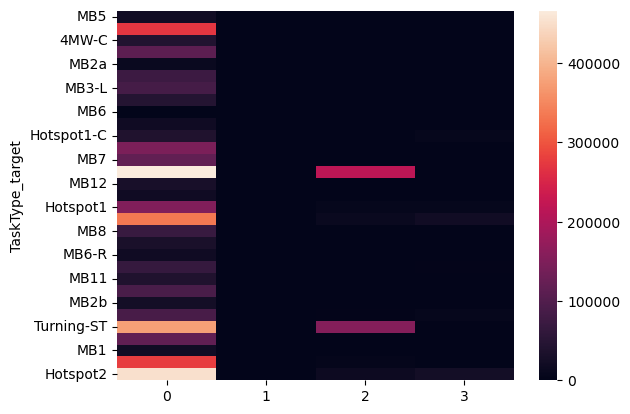

In [51]:
df_task_ct = df_task_ct.set_index("TaskType_target")
sns.heatmap(df_task_ct)

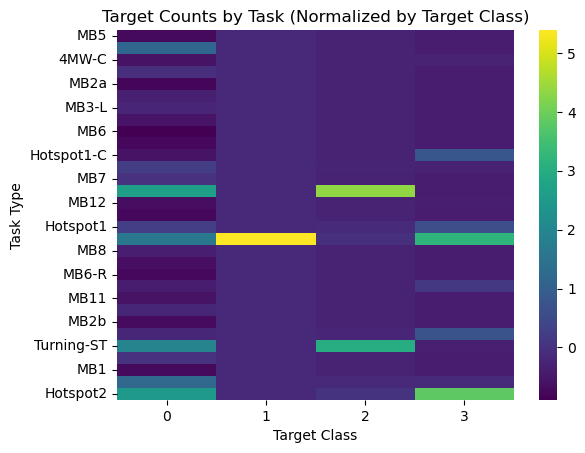

In [55]:
df_task_ct_norm = (df_task_ct-df_task_ct.mean())/df_task_ct.std()
sns.heatmap(df_task_ct_norm, cmap='viridis') \
    .set(title="Target Counts by Task (Normalized by Target Class)",
        ylabel="Task Type", xlabel="Target Class")
plt.show()

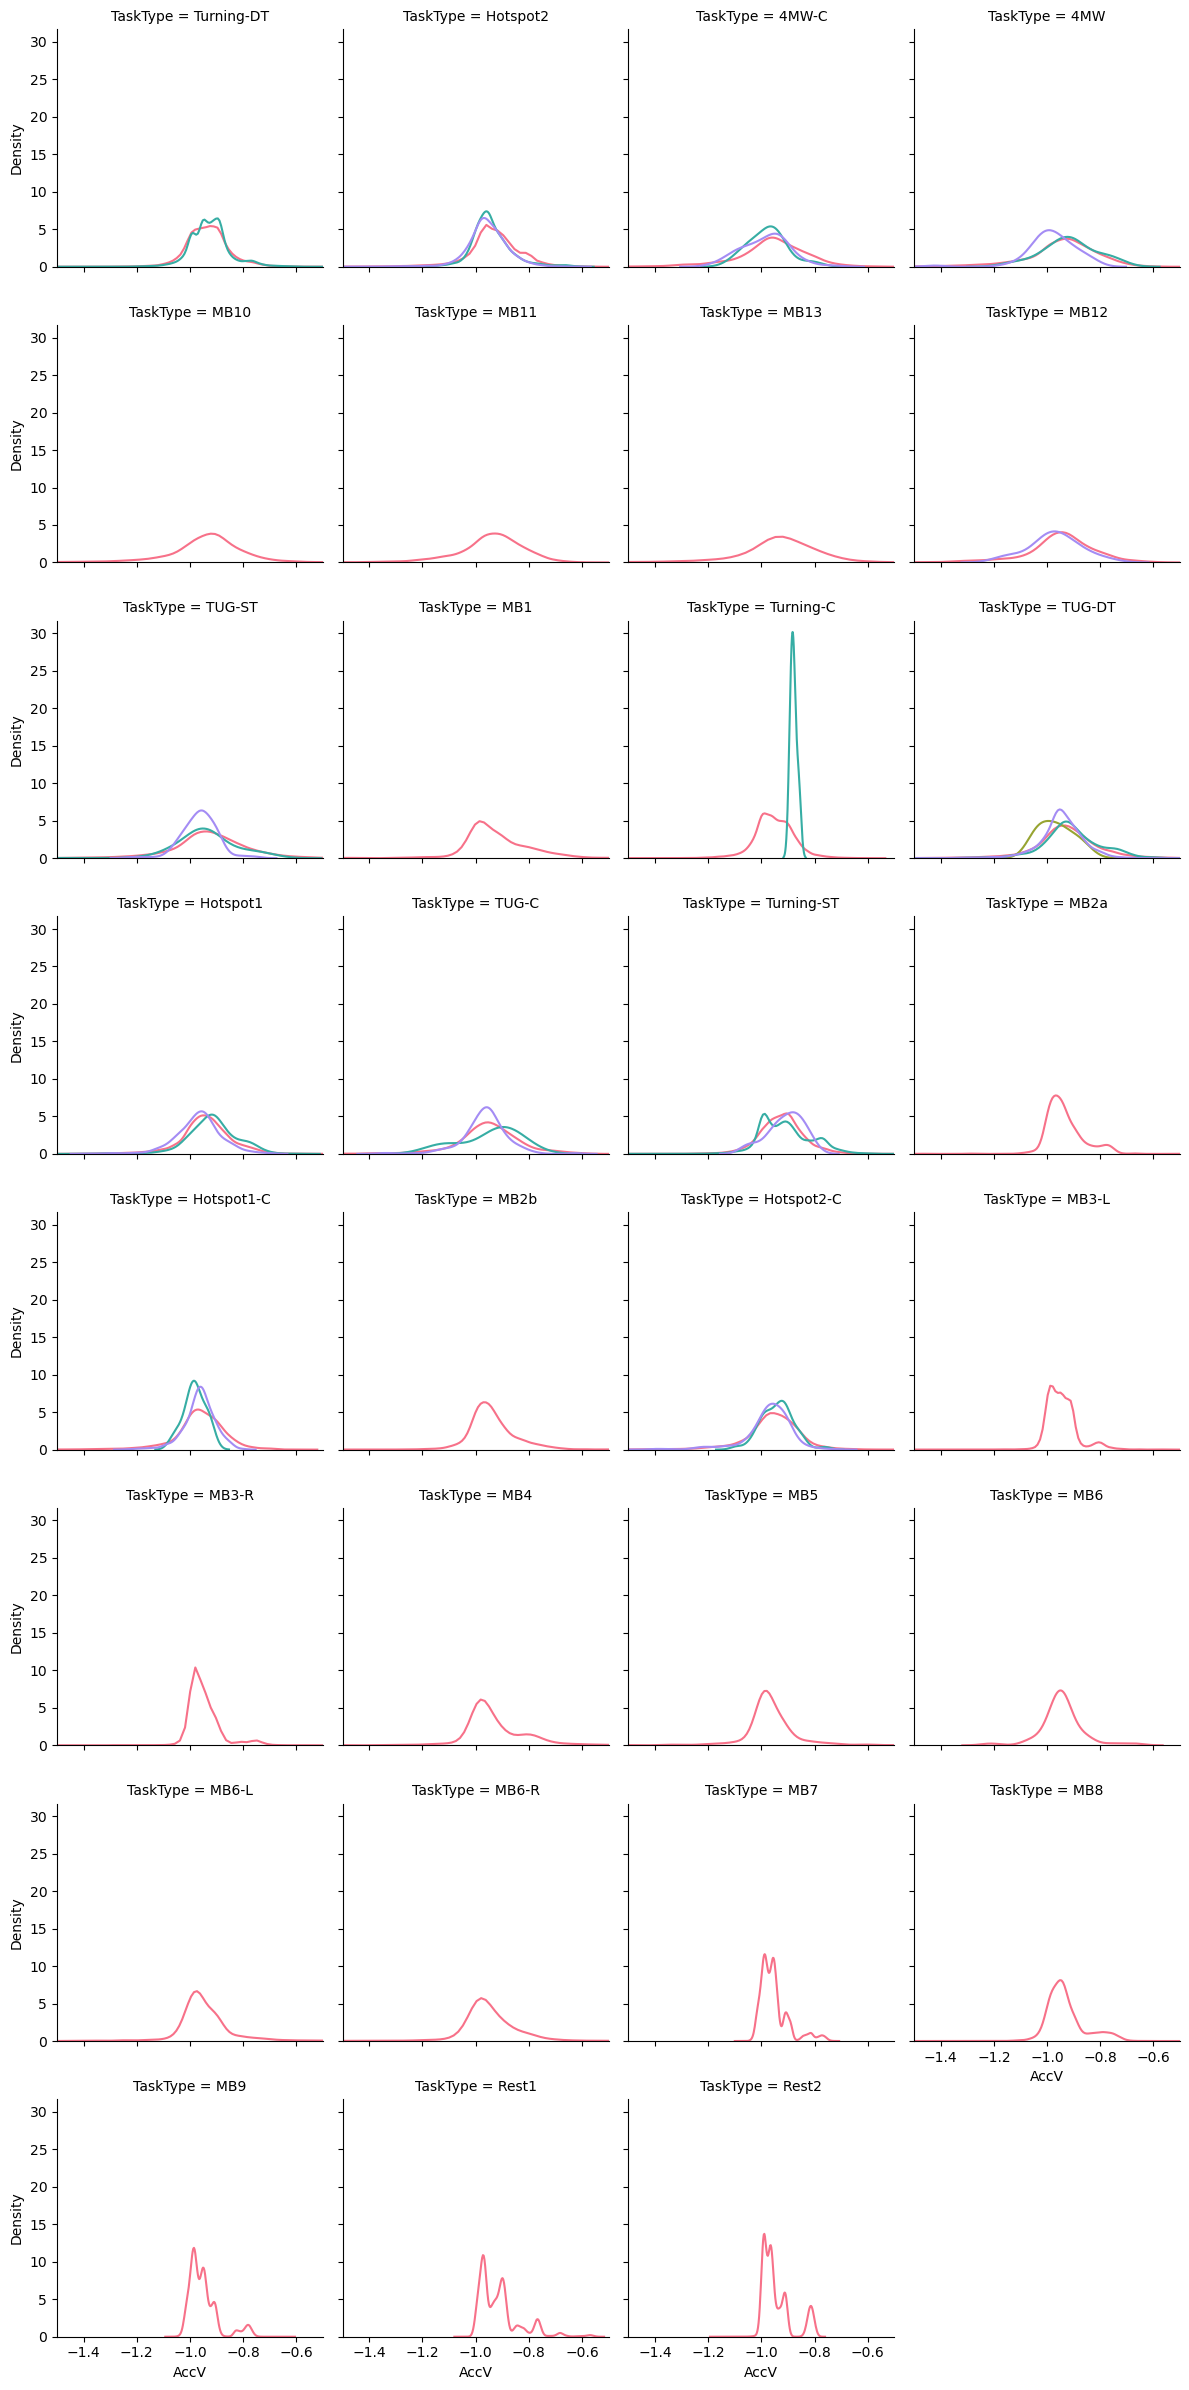

In [32]:
g = sns.FacetGrid(df_task_10perc, col_wrap=4, col="TaskType", hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "AccV", common_norm=False)
g.set(xlim=(-1.5,-0.5))

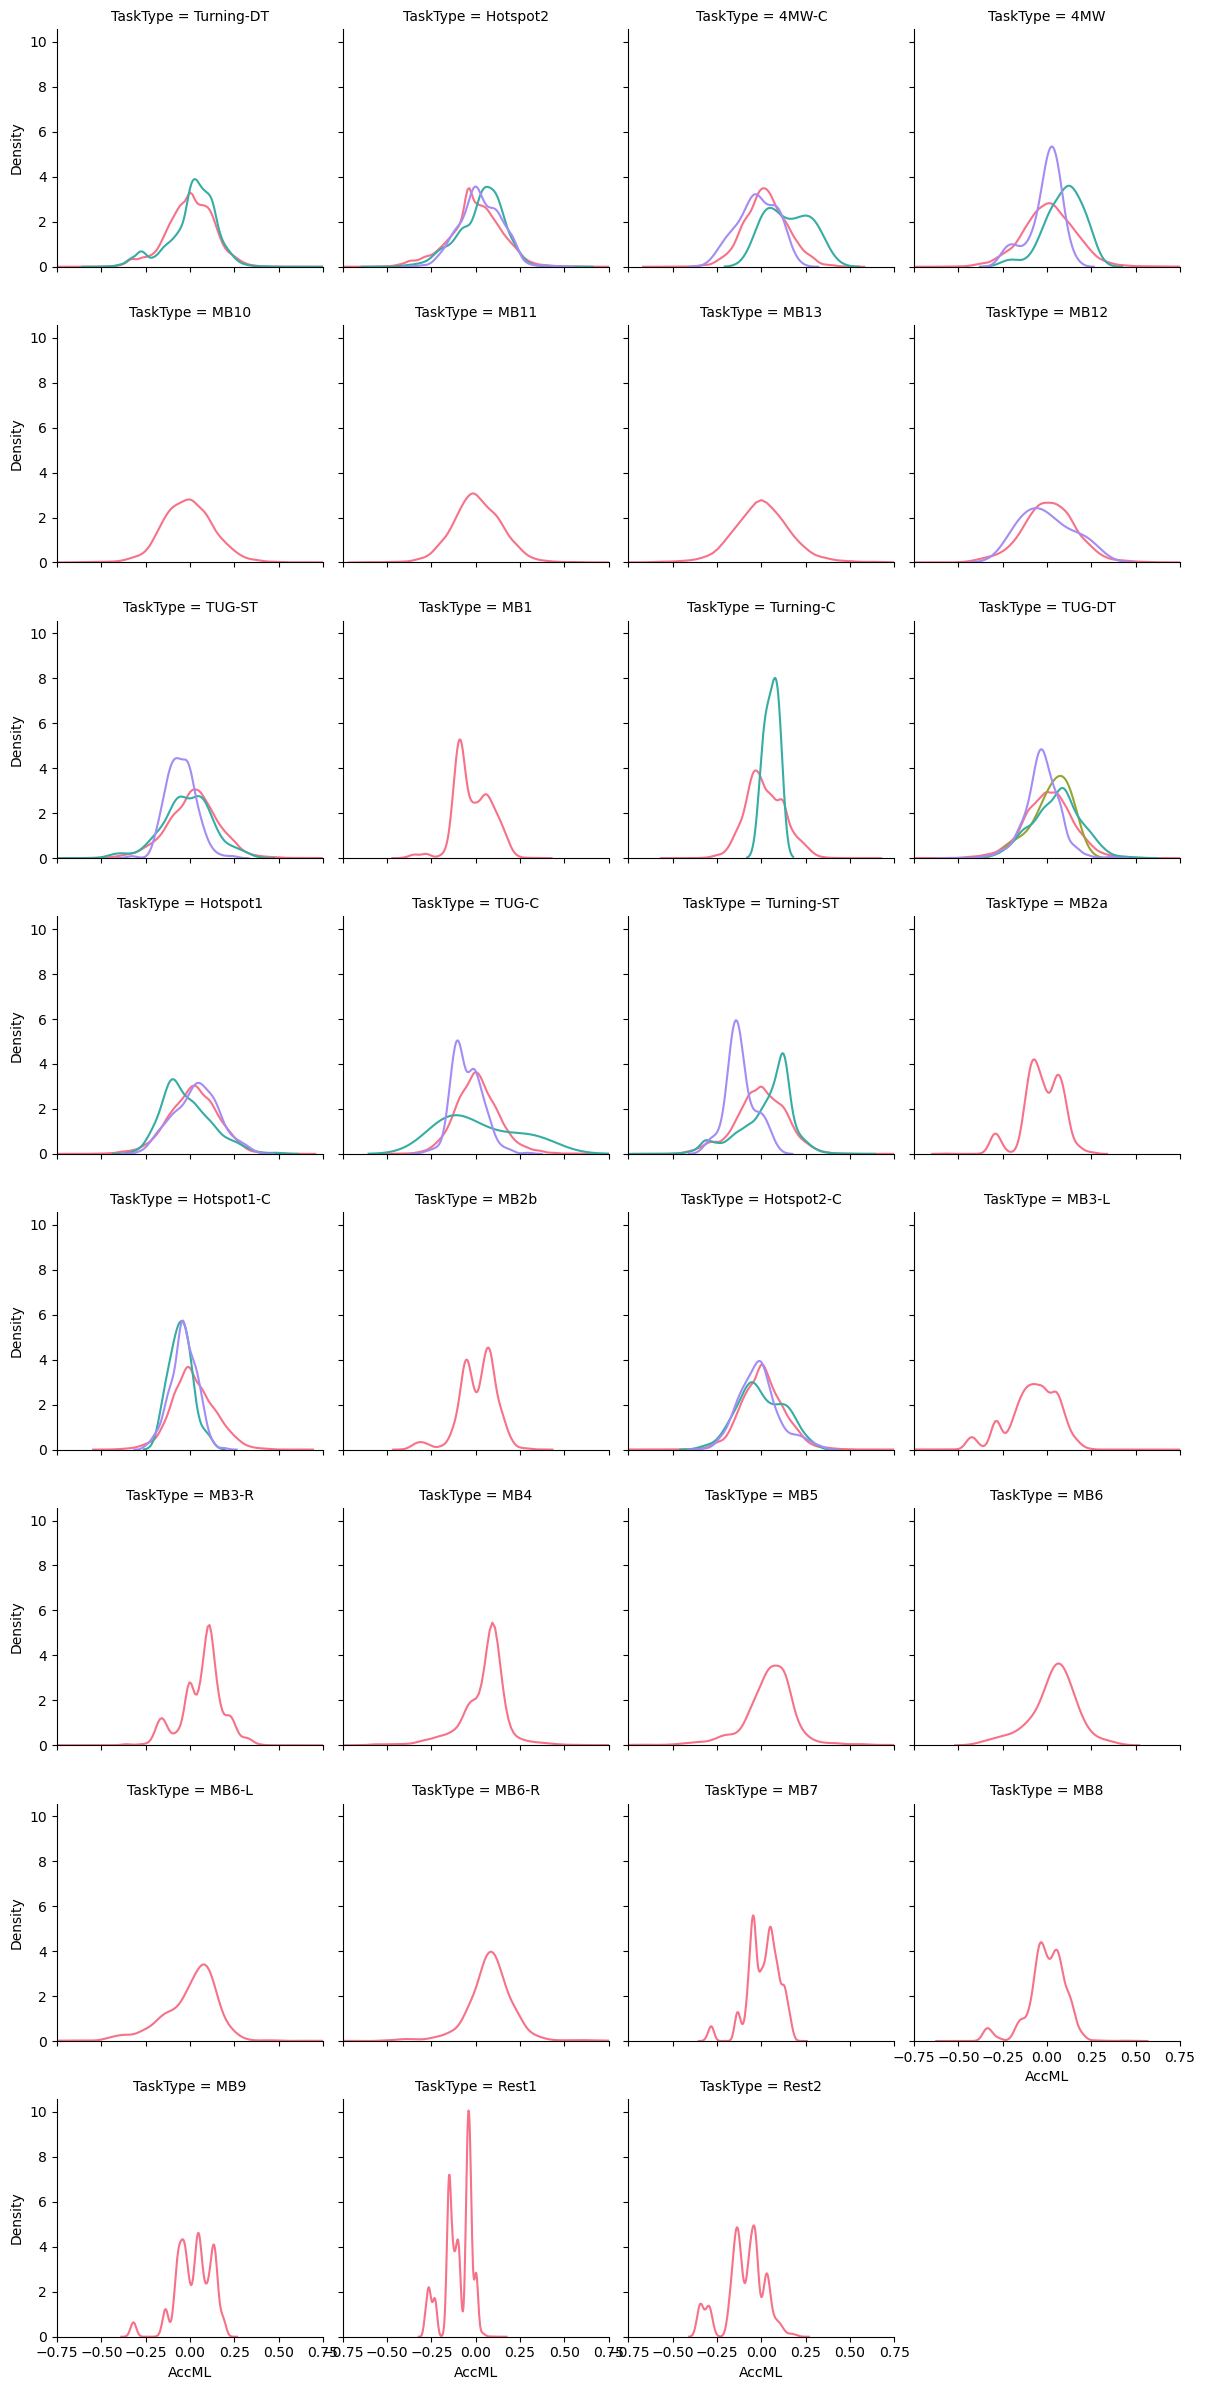

In [33]:
g = sns.FacetGrid(df_task_10perc, col_wrap=4, col="TaskType", hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "AccML", common_norm=False)
g.set(xlim=(-.75,.75))

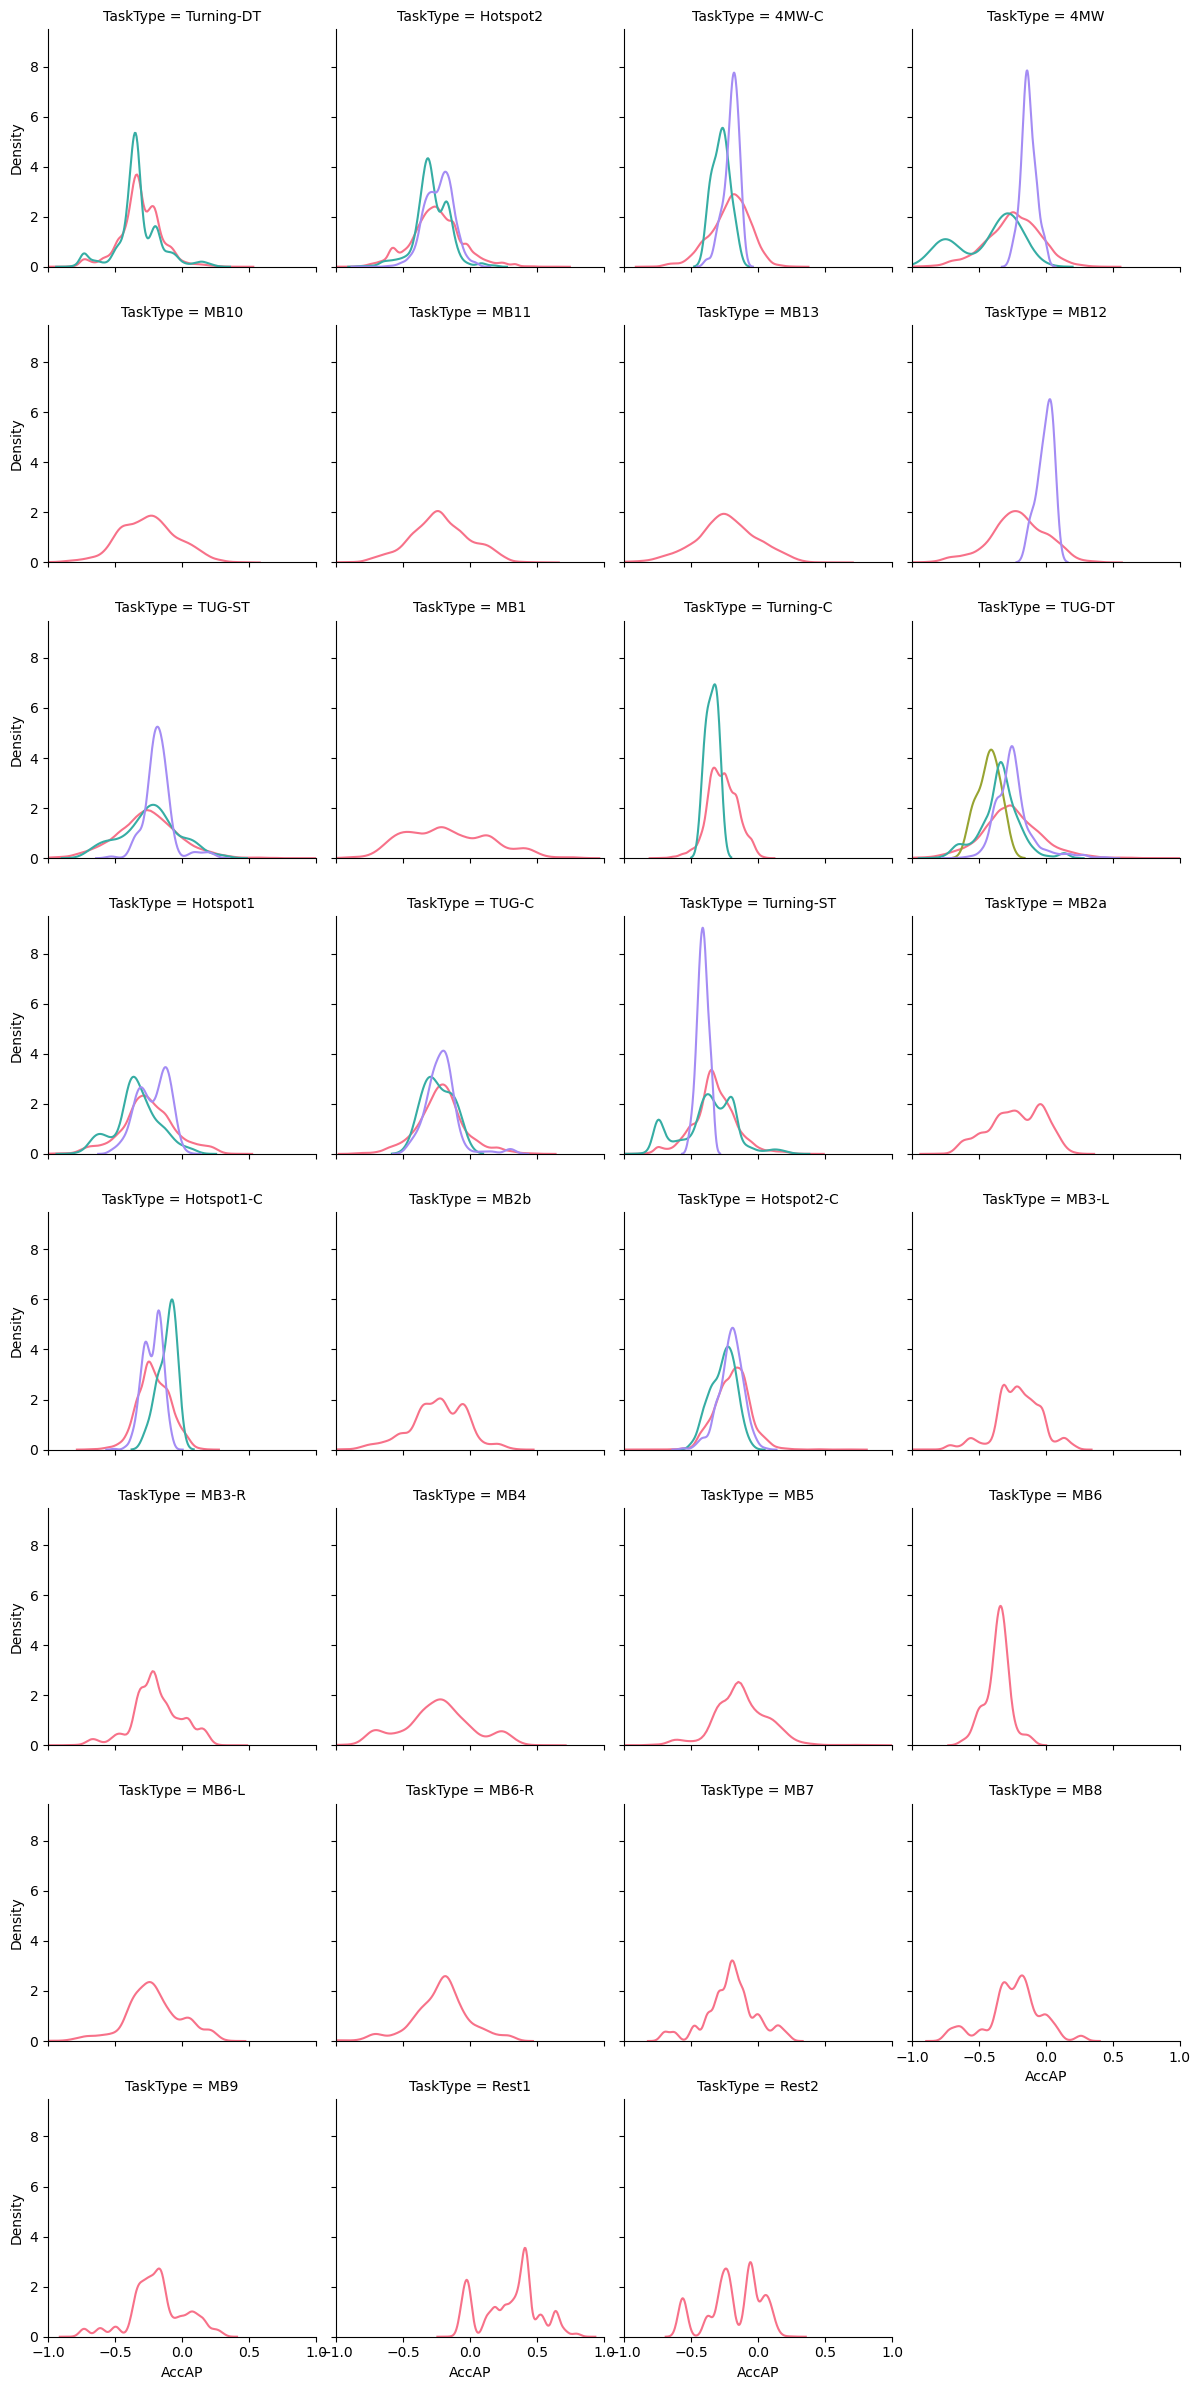

In [36]:
g = sns.FacetGrid(df_task_10perc, col_wrap=4, col="TaskType", hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "AccAP", common_norm=False)
g.set(xlim=(-1,1))


### Parkinson's Score and Task Distributions

[Text(0.5, 1.0, 'NFOGQ Score Distribution by Target Class')]

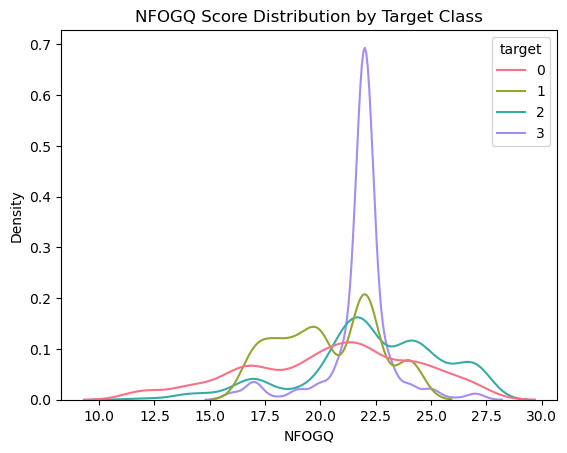

In [104]:
sns.kdeplot(data=df_sample, x="NFOGQ", hue="target", common_norm=False, palette=sns.color_palette("husl", 4)) \
    .set(title="NFOGQ Score Distribution by Target Class")

[Text(0.5, 1.0, 'Age Distribution by Target Class')]

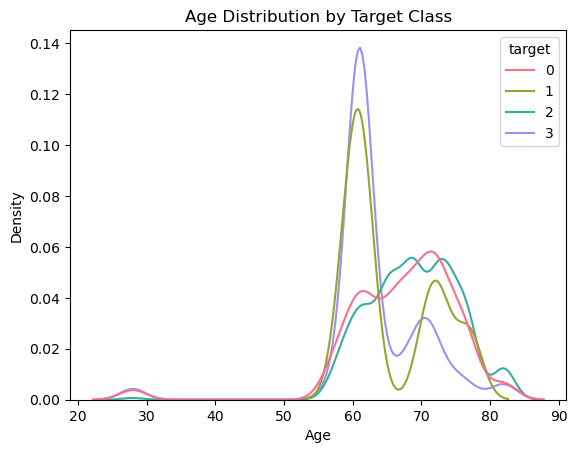

In [105]:
sns.kdeplot(data=df_sample, x="Age", hue="target", common_norm=False, palette=sns.color_palette("husl", 4)) \
    .set(title="Age Distribution by Target Class")

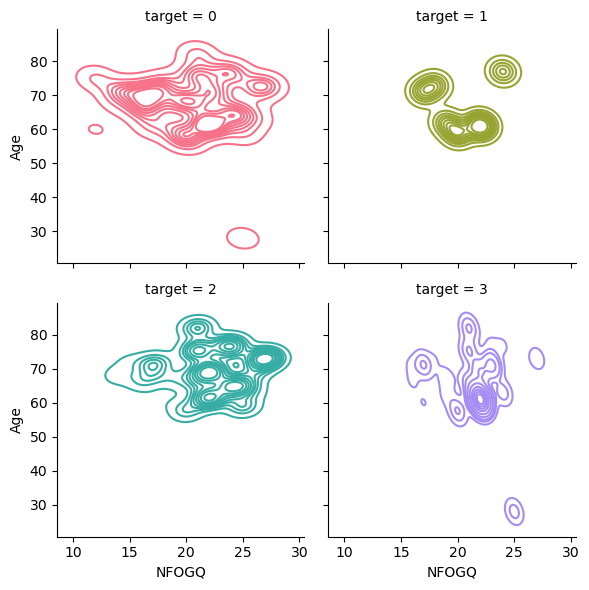

In [112]:
g = sns.FacetGrid(df_sample, col="target", col_wrap=2, hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "NFOGQ", "Age", common_norm=False)

<AxesSubplot:xlabel='NFOGQ', ylabel='Age'>

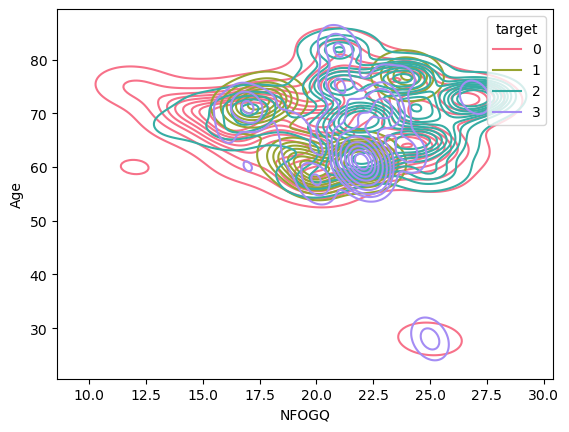

In [109]:
sns.kdeplot(data=df_sample, x="NFOGQ", y="Age", hue="target", common_norm=False, palette=sns.color_palette("husl", 4))

<AxesSubplot:xlabel='NFOGQ', ylabel='Density'>

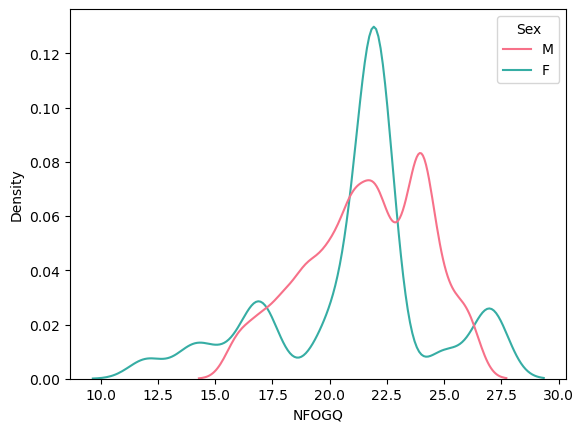

In [101]:
sns.kdeplot(data=df_sample, x="NFOGQ", hue="Sex", common_norm=True, palette=sns.color_palette("husl", 2))

<AxesSubplot:xlabel='Age', ylabel='Density'>

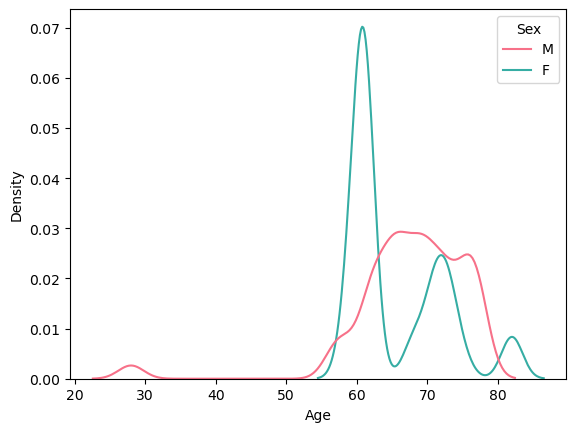

In [100]:
sns.kdeplot(data=df_sample, x="Age", hue="Sex", common_norm=True, palette=sns.color_palette("husl", 2))

In [81]:
df_sample.groupby('target').size()

target
0    1380
1     500
2    1148
3     866
dtype: int64

<AxesSubplot:xlabel='NFOGQ', ylabel='Density'>

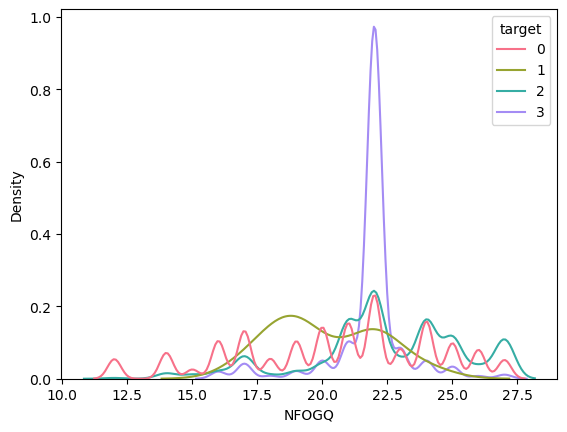

In [78]:
sns.kdeplot(data=acc_measures, x="NFOGQ", hue="target", common_norm=False, palette=sns.color_palette("husl", 4))

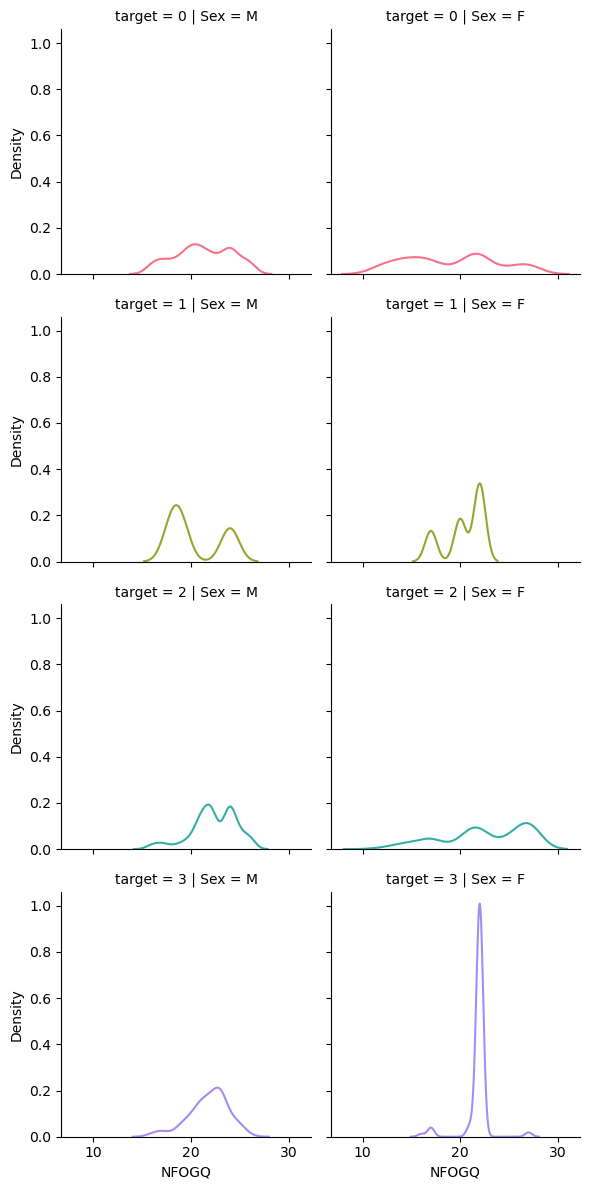

In [94]:
g = sns.FacetGrid(df_sample, col="Sex", row="target", hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "NFOGQ", common_norm=False)


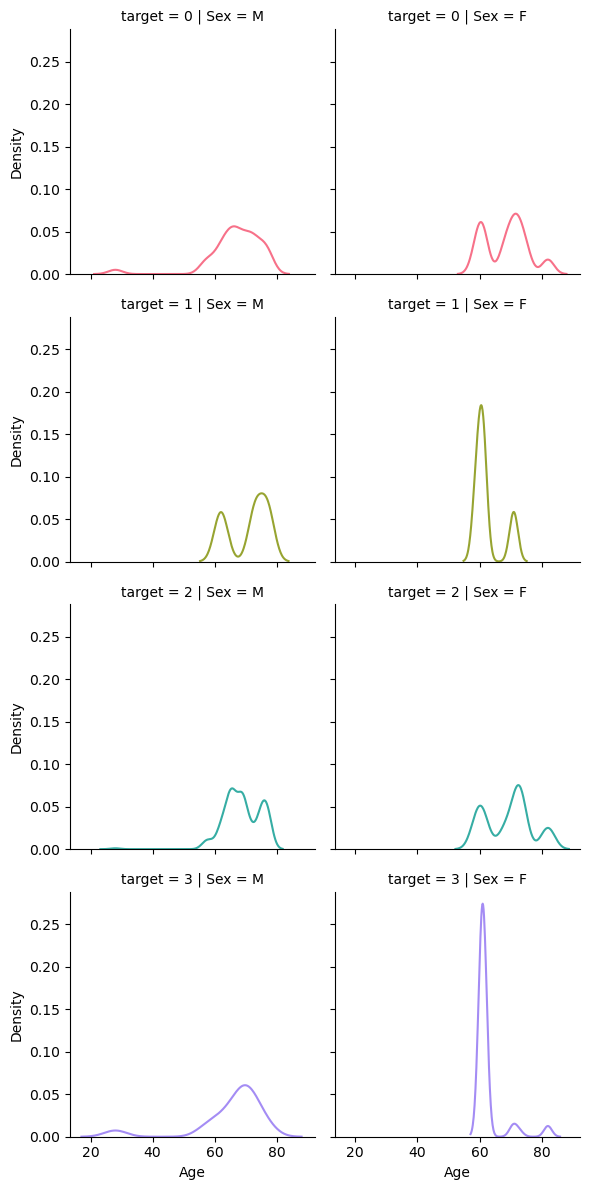

In [95]:
g = sns.FacetGrid(df_sample, col="Sex", row='target', hue="target", palette=sns.color_palette("husl", 4))
g.map(sns.kdeplot, "Age", common_norm=False)


In [88]:
df_sample.head()

,AccV,AccML,AccAP,NFOGQ,Age,Sex,Medication,target
0,-0.907298,0.062500,-0.343750,25,65,M,off,0
1,-0.953125,0.093750,-0.288784,25,65,M,on,0
2,-0.843750,0.092630,-0.202807,25,65,M,on,0
3,-0.921875,0.000000,-0.328125,24,65,M,on,0
4,-0.968750,0.078125,-0.046875,25,65,M,off,0
